In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.RandomVerticalFlip(p=1),
     transforms.RandomRotation(degrees = 45)
     ])

# transform_test=[transforms.ToTensor(),
#                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


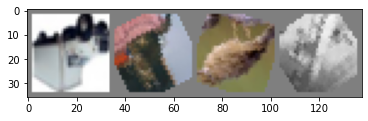

truck   cat  bird plane


torch.Size([4, 3, 32, 32])

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

images.shape

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
net=net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # accuracy source: https://discuss.pytorch.org/t/calculate-train-accuracy-of-the-model-in-segmentation-task/33581
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        #avg_accuracy = train_accuracy / len(train_loader)


        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            print("training accuracy : ",train_accuracy)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.600
training accuracy :  41.9875
[1,  4000] loss: 1.559
training accuracy :  42.60625
[1,  6000] loss: 1.543
training accuracy :  42.95
[1,  8000] loss: 1.522
training accuracy :  43.43125
[1, 10000] loss: 1.516
training accuracy :  43.8525
[1, 12000] loss: 1.502
training accuracy :  44.22083333333333
[2,  2000] loss: 1.453
training accuracy :  48.8125
[2,  4000] loss: 1.443
training accuracy :  48.58125
[2,  6000] loss: 1.442
training accuracy :  48.32083333333333
[2,  8000] loss: 1.431
training accuracy :  48.421875
[2, 10000] loss: 1.409
training accuracy :  48.72
[2, 12000] loss: 1.413
training accuracy :  48.75625
[3,  2000] loss: 1.370
training accuracy :  51.3
[3,  4000] loss: 1.376
training accuracy :  50.98125
[3,  6000] loss: 1.376
training accuracy :  51.1375
[3,  8000] loss: 1.375
training accuracy :  51.084375
[3, 10000] loss: 1.354
training accuracy :  51.18
[3, 12000] loss: 1.371
training accuracy :  51.235416666666666
[4,  2000] loss: 1.311
training a

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

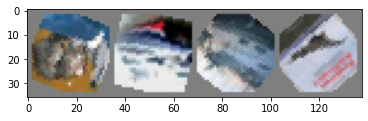

GroundTruth:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
net = Net()
net.to(device)
nwt=net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = net(images.to(device))

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


## Attempt 1 (default code):
### accuracy = 53%

## Attempt 2 :
added transforms to image : horizontal flip, vertical flip, rotation by 45 deg
(obseverd that accuracy of the car class was 70%)
###accuracy 47% ; min loss 1.503

##Attempt 3:
added one more fully connected layer in the middle

accuracy of class car reduced to 38% ; class truck increased to 71%; ship increased to 64%

###Accuracy 46% ; min loss 1.511

##Attempt 4:
increased epochs to 25
added train accuracy paramenter
###train accuracy 63.29%;test Accuracy 58% ; loss 1.041



In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# avg=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
#     avg+=100 * class_correct[i] / class_total[i]
# avg=avg/10

# print("average of 10 classes = ", avg)

Accuracy of plane : 67 %
Accuracy of   car : 73 %
Accuracy of  bird : 49 %
Accuracy of   cat : 31 %
Accuracy of  deer : 63 %
Accuracy of   dog : 49 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 78 %
Accuracy of truck : 41 %
